In [4]:
token ="dddc5ba0186a6283e58e11bf20c8b76bffc00e994597e332f19a71cf53393ffc3653034ddc222560ce1e8498e274e980954d2a2e7c8fb5ae4242a7d7f966dcd3"

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
    overwrite=True
)

In [6]:
# Load saved credentials
service = QiskitRuntimeService()

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
import random
import matplotlib.pyplot as plt

# Initialize IBM Quantum service
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")

# Store the quantum circuit used in stock prediction
quantum_circuit_used = None  

def generate_stock_data(num_days=365, filename="stock_data.txt"):
    """
    Generates random percentage changes between -100% and +100% for num_days
    and writes them to a file.
    """
    stock_changes = [round(random.uniform(-100.00, 100.00), 2) for _ in range(num_days)]

    # Write to file
    with open(filename, "w") as file:
        for change in stock_changes:
            file.write(f"{change:.2f}\n")

    print(f"Stock data successfully written to {filename}")

def predict_stock_purchases(filename="stock_data.txt", initial_price=200):
    """
    Uses a single quantum job to predict stock purchases for the entire dataset.
    """
    global quantum_circuit_used  # Allow storing the actual circuit

    # Read stock data
    with open(filename, "r") as file:
        stock_changes = [float(line.strip()) / 100 for line in file.readlines()]

    num_days = len(stock_changes)
    portfolio = {"shares": 0, "initial_price": initial_price}

    # Create a batch of circuits for all 90-day rolling windows
    circuits = []
    for i in range(num_days - 89):  # Rolling window analysis
        qc = QuantumCircuit(2)
        qc.h(0)  # Superposition for uncertainty
        qc.cx(0, 1)  # Entanglement for correlated movements
        qc.measure_all()
        circuits.append(qc)

    # Store the last quantum circuit used for visualization later
    quantum_circuit_used = circuits[-1]  

    # Transpile once for all circuits
    transpiled_circuits = transpile(circuits, backend, optimization_level=3)

    # Run **all circuits in one job**
    with Session(backend=backend) as session:
        sampler = Sampler()
        job = sampler.run(transpiled_circuits, shots=50)  # ✅ Single batch job
        results = job.result()

    # Process all results at once
    for i, result in enumerate(results):
        avg_change = sum(stock_changes[i:i + 90]) / 90
        samples = result.data.meas.get_counts()
        outcome = random.choices(population=list(samples.keys()), weights=list(samples.values()))[0]

        # Predict price
        if avg_change < 0:
            predicted_price = (1 + avg_change) * portfolio["initial_price"]
        else:
            predicted_price = portfolio["initial_price"] * (1 + avg_change)

        # Decision-making
        shares_to_buy = 0
        if predicted_price < 67:
            shares_to_buy = 0
        elif 67 <= predicted_price <= 200:
            shares_to_buy = 150
        else:
            shares_to_buy = 50

        # Update portfolio
        portfolio["shares"] += shares_to_buy
        portfolio["initial_price"] = predicted_price

    # Final portfolio value calculation
    final_value = portfolio["shares"] * portfolio["initial_price"]
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Shares Owned: {portfolio['shares']}")
    print(f"Final Stock Price: ${portfolio['initial_price']:.2f}")

def visualize_real_quantum_circuit():
    """
    Displays the actual quantum circuit used in stock predictions.
    """
    if quantum_circuit_used is None:
        print("No quantum circuit available. Run predictions first.")
        return
    
    # ✅ Now displays the actual circuit used
    fig, ax = plt.subplots(figsize=(8, 3))
    quantum_circuit_used.draw(output="mpl", ax=ax)
    plt.show()

# Run Everything
generate_stock_data()
predict_stock_purchases()
visualize_real_quantum_circuit()  # ✅ Shows the actual quantum circuit AFTER execution


Using backend: ibm_brisbane
Stock data successfully written to stock_data.txt


Stock data successfully written to stock_data.txt
Final Portfolio Value: $16506.97
Total Shares Owned: 2700
Final Stock Price: $6.11


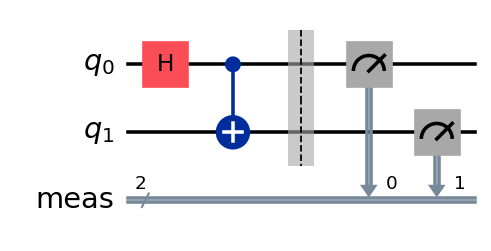

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import StatevectorSampler  # ✅ Latest replacement for SamplerV2
import random
import matplotlib.pyplot as plt

# Store the quantum circuit used for visualization later
quantum_circuit_used = None

def generate_stock_data(num_days=365, filename="stock_data.txt"):
    """
    Generates random percentage changes between -100% and +100% for num_days
    and writes them to a file.
    """
    stock_changes = [round(random.uniform(-100.00, 100.00), 2) for _ in range(num_days)]

    # Write to file
    with open(filename, "w") as file:
        for change in stock_changes:
            file.write(f"{change:.2f}\n")

    print(f"Stock data successfully written to {filename}")

def predict_stock_purchases(filename="stock_data.txt", initial_price=200):
    """
    Uses a local quantum simulator (Qiskit StatevectorSampler) to predict stock purchases.
    """
    global quantum_circuit_used  # Store circuit for visualization later

    # Read stock data
    with open(filename, "r") as file:
        stock_changes = [float(line.strip()) / 100 for line in file.readlines()]

    num_days = len(stock_changes)
    portfolio = {"shares": 0, "initial_price": initial_price}

    stock_price_history = [initial_price]
    portfolio_value_history = []

    # Create a batch of circuits for all 90-day rolling windows
    circuits = []
    for i in range(num_days - 89):  # Rolling window analysis
        qc = QuantumCircuit(2)
        qc.h(0)  # Superposition for uncertainty
        qc.cx(0, 1)  # Entanglement for correlated movements
        qc.measure_all()
        circuits.append(qc)

    # Store the last quantum circuit used for visualization later
    quantum_circuit_used = circuits[-1]  

    # Use Qiskit’s local StatevectorSampler to run all circuits
    sampler = StatevectorSampler()
    job = sampler.run(circuits)
    results = job.result()

    # Process all results at once
    for i, result in enumerate(results):
        avg_change = sum(stock_changes[i:i + 90]) / 90
        samples = result.data.meas.get_counts()
        outcome = max(samples, key=samples.get)  # Get most likely measurement outcome

        # Predict price
        if avg_change < 0:
            predicted_price = (1 + avg_change) * portfolio["initial_price"]
        else:
            predicted_price = portfolio["initial_price"] * (1 + avg_change)

        # Decision-making
        shares_to_buy = 0
        if predicted_price < 67:
            shares_to_buy = 0
        elif 67 <= predicted_price <= 200:
            shares_to_buy = 150
        else:
            shares_to_buy = 50

        # Update portfolio
        portfolio["shares"] += shares_to_buy
        portfolio["initial_price"] = predicted_price

    # Final portfolio value calculation
    final_value = portfolio["shares"] * portfolio["initial_price"]
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Shares Owned: {portfolio['shares']}")
    print(f"Final Stock Price: ${portfolio['initial_price']:.2f}")

def visualize_real_quantum_circuit():
    """
    Displays the actual quantum circuit used in stock predictions.
    """
    if quantum_circuit_used is None:
        print("No quantum circuit available. Run predictions first.")
        return
    
    # ✅ Now displays the actual circuit used
    fig, ax = plt.subplots(figsize=(8, 3))
    quantum_circuit_used.draw(output="mpl", ax=ax)
    plt.show()

# Run Everything
generate_stock_data()
predict_stock_purchases()
visualize_real_quantum_circuit()  # ✅ Shows the actual quantum circuit AFTER execution
